Mask the binary water products with the ice mask products

In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
from skimage.filters import threshold_otsu

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025") \
            .sort_values('o2region', ascending=False)

In [4]:
# process each glacier
gdf_to_use = rgi_gdf

# subset to just a single glacier for testing
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-14-11612'] # baltoro
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-15-08331'] # khumbu
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-15-06758'] # lhotse
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-15-06763'] # imja
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-15-06794'] # ama dablam
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-15-05762'] # no water expected
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-15-09530'] # proglacial development
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-15-09532'] # complex proglacial, lots of icebergs
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-15-05619'] # simple proglacial

c=0
for idx, row in gdf_to_use.iterrows():
    c+=1
    # if c>1: continue

    # grab glacier regions, rgiid, area
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    
    # if o1region!='15': continue
    # if rgi_id != "RGI2000-v7.0-G-14-11612": continue
    # print(c, "of", len(rgi_gdf), rgi_id)
    
    # print progress
    if c%10==1: print(c, "of", len(rgi_gdf), rgi_id)
    
    # open glacier mask, debris mask
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'glacier_mask.tif')
    xr_gmask = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'debris_mask.tif')
    xr_dmask = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    xr_gmask = xr_gmask.where(xr_gmask==1)
    xr_dmask = xr_dmask.where(xr_dmask==1)
    
    # make dmask nan
    xr_dmask = xr_dmask.where(xr_dmask==1, np.nan)
    
    # open water
    path_open = os.path.join(folder_glaciers, rgi_id, 'Water', 'debris_binary_water_otsuoptimal_137_accaqa.tif') #188 137
    xr_water = riox.open_rasterio(path_open, masked=True, chunks={'band':'auto'}).astype(float)
    xr_water = xr_water.rename({"band":"year"})
    xr_water['year'] = [str(i) for i in list(xr_water.long_name)]
    xr_water = xr_water.where(xr_water!=255,np.nan)
    # xr_water = xr_water*xr_dmask
    
    # open ice
    path_open = os.path.join(folder_glaciers, rgi_id, 'SnowIce', 'debris_snice_binary_acca.tif')
    xr_ice = riox.open_rasterio(path_open, masked=True, chunks={'band':'auto'}).astype(float)
    xr_ice = xr_ice.rename({"band":"year"})
    xr_ice['year'] = [str(i) for i in list(xr_ice.long_name)]
    # xr_ice = xr_ice.where(xr_ice!=255,np.nan)
    
    # buffer ice by 2 pixels (5-pixel width convolution)
    xr_ice = xr_ice.where(~np.isnan(xr_ice),0)
    xr_ice = xr_ice.rolling({"x":5,"y":5}, center=True, min_periods=1).max()
    xr_ice = xr_ice.where(~np.isnan(xr_dmask),np.nan)
    
    # mask water with ice
    xr_water_masked = xr_water.where(xr_ice<1,0)
    
    # make sure off-debris is nan, then fill nans with 255
    xr_water_masked = xr_water_masked*xr_dmask
    xr_water_masked = xr_water_masked.fillna(255).assign_attrs(nodata=255).astype('uint8')
    
    # save to folder
    out_path = os.path.join(folder_glaciers, rgi_id, 'Water', 'debris_binary_water_otsuoptimal_137_icemasked_accaqa.tif') #188 137
    xr_water_masked.to_dataset(dim='year').rio.to_raster(out_path, compress='LZW', tiled=True)
    
    # break
    
    # break
        
print("All done!")

1 of 769 RGI2000-v7.0-G-15-18123
11 of 769 RGI2000-v7.0-G-15-14680
21 of 769 RGI2000-v7.0-G-15-18022
31 of 769 RGI2000-v7.0-G-15-17010
41 of 769 RGI2000-v7.0-G-15-07551
51 of 769 RGI2000-v7.0-G-15-07902
61 of 769 RGI2000-v7.0-G-15-08295
71 of 769 RGI2000-v7.0-G-15-06174
81 of 769 RGI2000-v7.0-G-15-08331
91 of 769 RGI2000-v7.0-G-15-06797
101 of 769 RGI2000-v7.0-G-15-09528
111 of 769 RGI2000-v7.0-G-15-09893
121 of 769 RGI2000-v7.0-G-15-11159
131 of 769 RGI2000-v7.0-G-15-08804
141 of 769 RGI2000-v7.0-G-15-08688
151 of 769 RGI2000-v7.0-G-15-09257
161 of 769 RGI2000-v7.0-G-15-01666
171 of 769 RGI2000-v7.0-G-15-01448
181 of 769 RGI2000-v7.0-G-15-01313
191 of 769 RGI2000-v7.0-G-15-01905
201 of 769 RGI2000-v7.0-G-15-00665
211 of 769 RGI2000-v7.0-G-15-00434
221 of 769 RGI2000-v7.0-G-15-00711
231 of 769 RGI2000-v7.0-G-15-00982
241 of 769 RGI2000-v7.0-G-15-02276
251 of 769 RGI2000-v7.0-G-15-05124
261 of 769 RGI2000-v7.0-G-15-05421
271 of 769 RGI2000-v7.0-G-15-02282
281 of 769 RGI2000-v7.0-G-15-05

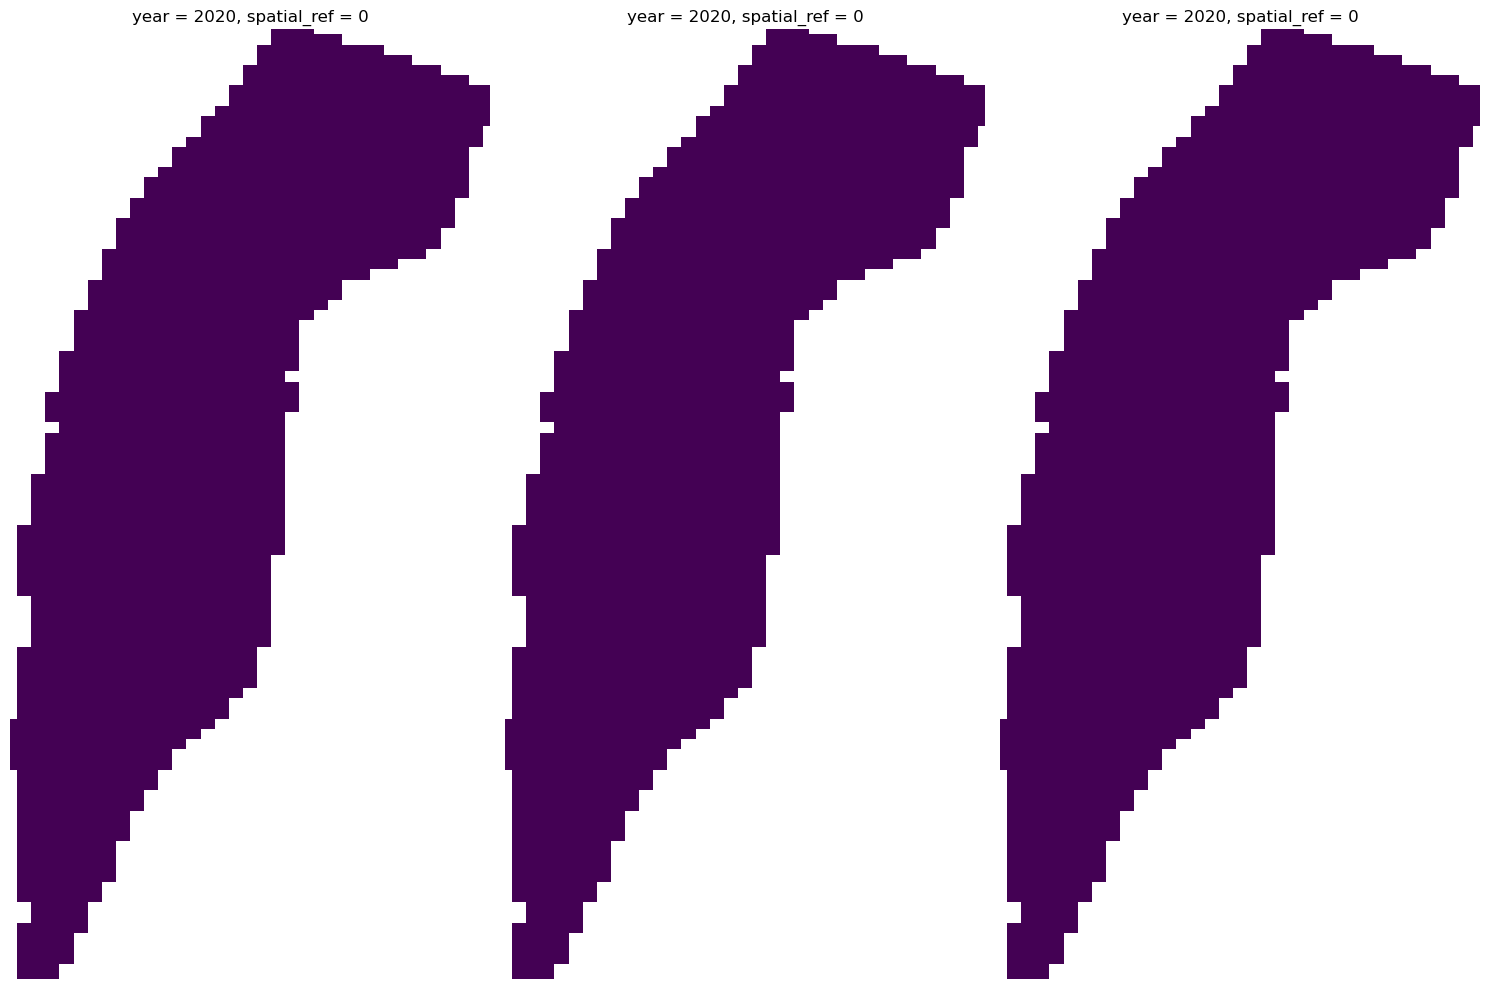

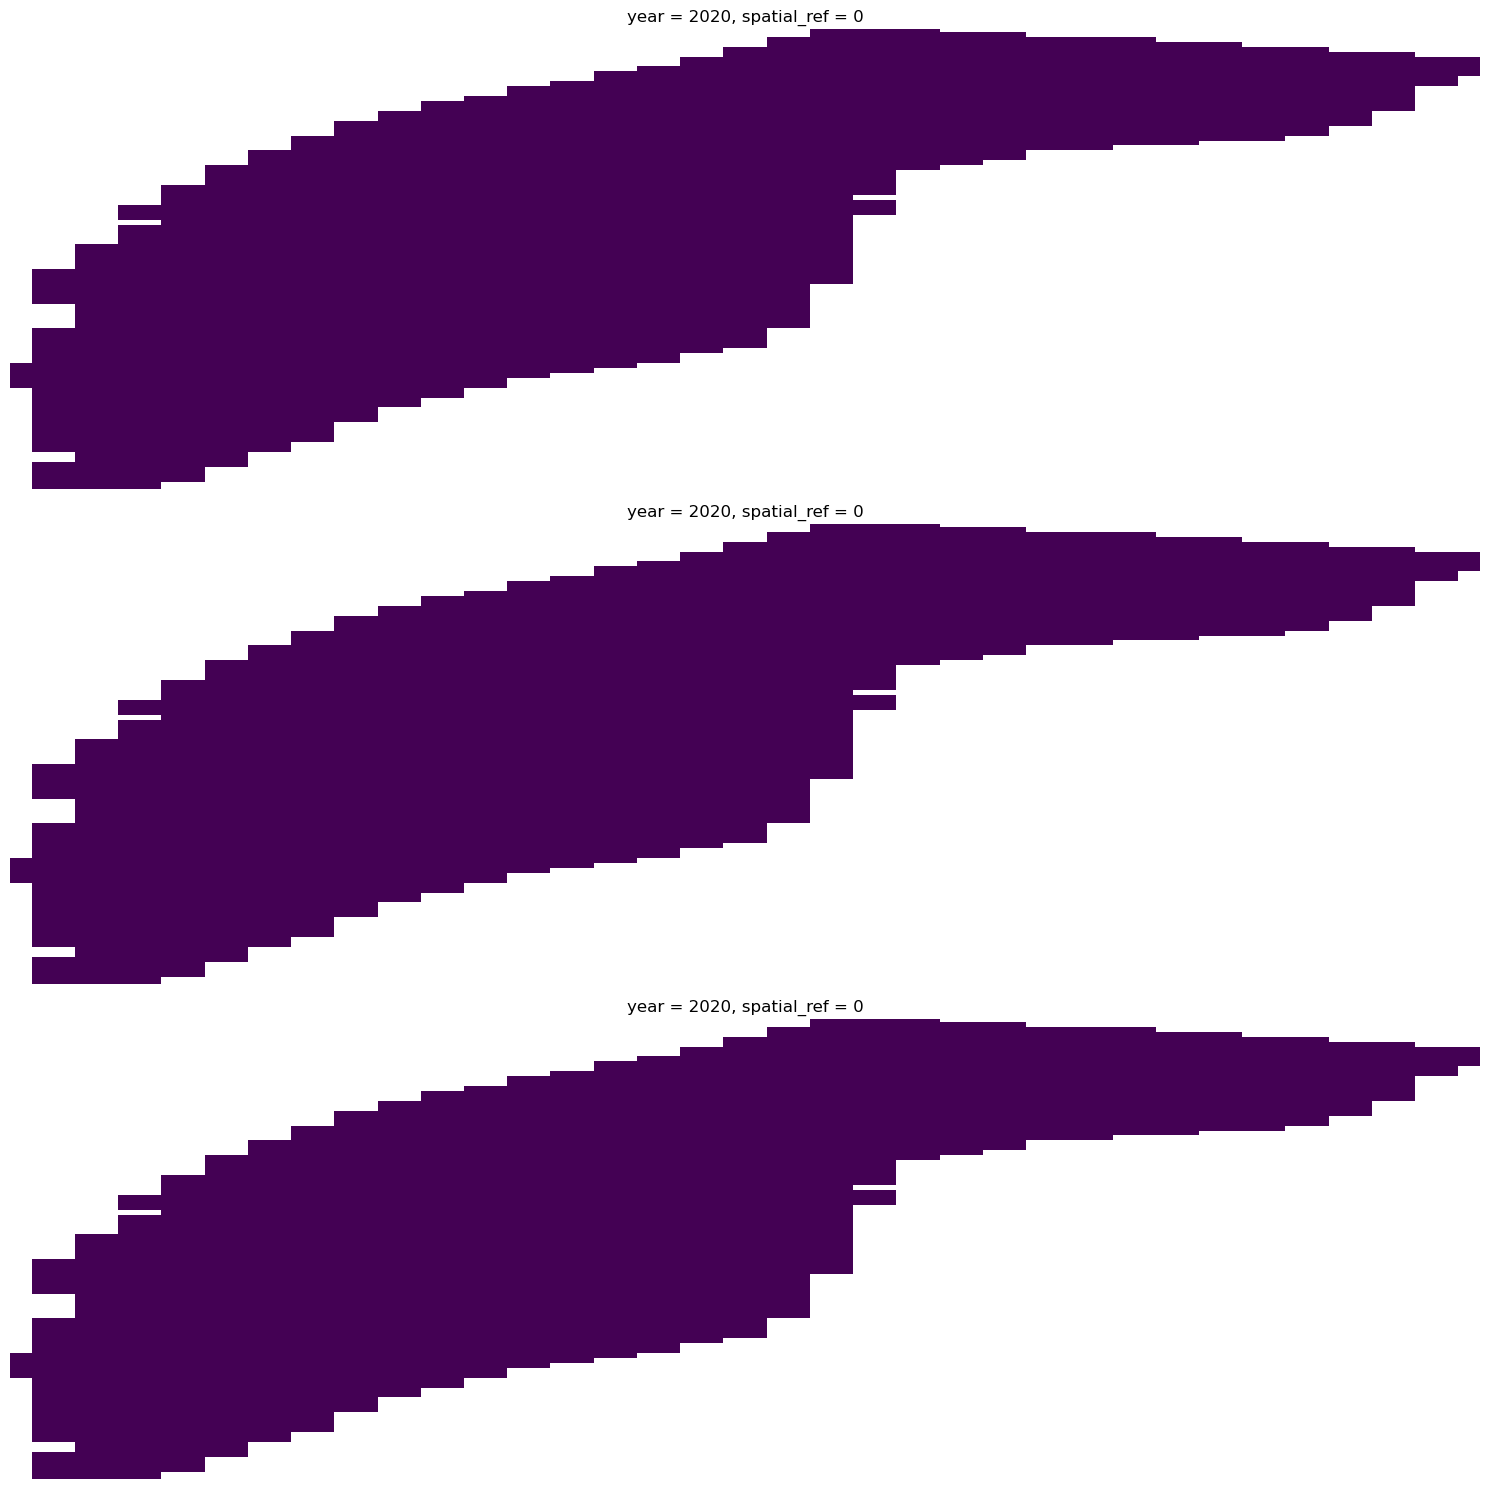

In [5]:
# plot single year's data
y='2020'
binary_w = xr_water.sel(year=y)*xr_dmask
binary_i = xr_ice.sel(year=y)*xr_dmask
binary_wm = xr_water_masked.sel(year=y)*xr_dmask

bounds_y = binary_w.y.values[ xr.where(binary_w==0, 1, 0).sum(dim='x').values > 0 ]
bounds_x = binary_w.x.values[ xr.where(binary_w==0, 1, 0).sum(dim='y').values > 0 ]

fig,axs = plt.subplots(1,3, figsize=(15,10))
binary_w.plot(ax=axs[0], add_colorbar=False, vmin=0, vmax=2)
binary_i.plot(ax=axs[1], add_colorbar=False, vmin=0, vmax=2)
binary_wm.plot(ax=axs[2], add_colorbar=False, vmin=0, vmax=2)

for ax in axs:
    ax.set_xlim(min(bounds_x), max(bounds_x))
    ax.set_ylim(min(bounds_y), max(bounds_y))
    # ax.axis('equal')
    ax.axis('off')
plt.tight_layout()

fig,axs = plt.subplots(3,1, figsize=(15,15))
binary_w.plot(ax=axs[0], add_colorbar=False, vmin=0, vmax=2)
binary_i.plot(ax=axs[1], add_colorbar=False, vmin=0, vmax=2)
binary_wm.plot(ax=axs[2], add_colorbar=False, vmin=0, vmax=2)

for ax in axs:
    ax.set_xlim(min(bounds_x), max(bounds_x))
    ax.set_ylim(min(bounds_y), max(bounds_y))
    # ax.axis('equal')
    ax.axis('off')
plt.tight_layout()